In [59]:
import pandas as pd

df = pd.read_csv("/Users/burakbozatli/Desktop/data/shippingdata.csv")
print(df.head())

   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44           1233            

In [60]:
num_cols = ["Customer_care_calls","Customer_rating","Cost_of_the_Product",
            "Prior_purchases","Discount_offered","Weight_in_gms"]

cat_cols = ["Warehouse_block","Mode_of_Shipment","Product_importance","Gender"]

df[num_cols + cat_cols].head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,4,2,177,3,44,1233,D,Flight,low,F
1,4,5,216,2,59,3088,F,Flight,low,M
2,2,2,183,4,48,3374,A,Flight,low,M
3,3,3,176,4,10,1177,B,Flight,medium,M
4,2,2,184,3,46,2484,C,Flight,medium,F


In [61]:
#kategorik sütunları one-hot encodinge çevirmemiz gerek sayısallar direkt kullanılabilir.

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

X_cat = pd.get_dummies(df[cat_cols], drop_first=True)

X_num = df[num_cols].astype(float)

X = pd.concat([X_num, X_cat], axis=1)

X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X.shape, X_scaled.shape, X.head()


((10999, 15),
 (10999, 15),
    Customer_care_calls  Customer_rating  Cost_of_the_Product  Prior_purchases  \
 0                  4.0              2.0                177.0              3.0   
 1                  4.0              5.0                216.0              2.0   
 2                  2.0              2.0                183.0              4.0   
 3                  3.0              3.0                176.0              4.0   
 4                  2.0              2.0                184.0              3.0   
 
    Discount_offered  Weight_in_gms  Warehouse_block_B  Warehouse_block_C  \
 0              44.0         1233.0              False              False   
 1              59.0         3088.0              False              False   
 2              48.0         3374.0              False              False   
 3              10.0         1177.0               True              False   
 4              46.0         2484.0              False               True   
 
    Warehouse_

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, Model

input_dim = X_scaled.shape[1]

inp = layers.Input(shape=(input_dim,))
h1  = layers.Dense(min(64, input_dim//2), activation="relu")(inp)
h2  = layers.Dense(max(8,  input_dim//8), activation="relu")(h1)
h3  = layers.Dense(min(64, input_dim//2), activation="relu")(h2)
out = layers.Dense(input_dim, activation="linear")(h3)

ae = Model(inp, out)
ae.compile(optimizer="adam", loss="mse")

hist = ae.fit(
    X_scaled, X_scaled,
    epochs=20, batch_size=256, shuffle=True, validation_split=0.1, verbose=1
)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0229 - val_loss: 0.9418
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.9784 - val_loss: 0.9089
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.9432 - val_loss: 0.8712
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.9013 - val_loss: 0.8320
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.8589 - val_loss: 0.7942
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.8190 - val_loss: 0.7576
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.7787 - val_loss: 0.7210
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.7414 - val_loss: 0.6861
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.7050 - val_loss: 0.6476
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.6677 - val_loss: 0.6087
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.6336 - val_loss: 0.5790
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step -

In [64]:
#Loss ve val_loss birlikte ve düzenli azaldığı için modelin hem eğitim hem doğrulama verisini iyi temsil ettiği (overfitting belirtisi yok)görülür;
#bu nedenle her örnek için rekonstrüksiyon hatasını anomali skoru olarak kullanıp en yüksek %5’lik dilimi “anomali” kullanmak daha mantıklı.


In [65]:
import numpy as np

recon = ae.predict(X_scaled, verbose=0)
mse = np.mean((X_scaled - recon)**2, axis=1)

thr = np.percentile(mse, 95)  # üst %5
df["recon_error"] = mse
df["is_anomaly"] = (mse > thr).astype(int)

print(f"Eşik: {thr:.6f} | Anomali oranı: {df['is_anomaly'].mean():.3f}")

Eşik: 0.933276 | Anomali oranı: 0.050


In [66]:
cols_view = ["recon_error","is_anomaly","Customer_care_calls","Customer_rating",
             "Cost_of_the_Product","Prior_purchases","Discount_offered","Weight_in_gms",
             "Warehouse_block","Mode_of_Shipment","Product_importance","Gender"]

df.sort_values("recon_error", ascending=False).loc[:, cols_view].head(10)


,recon_error,is_anomaly,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
3563,2.136277,1,2,5,134,10,8,5472,F,Flight,high,M
3591,2.092518,1,2,3,134,10,1,5632,B,Ship,high,F
3177,2.082786,1,2,1,274,10,1,5622,B,Ship,high,F
3153,2.071895,1,3,2,153,10,2,5455,B,Flight,high,M
2091,2.014670,1,2,4,225,10,56,3384,B,Ship,high,M
2067,1.967839,1,2,4,225,10,46,2690,B,Flight,high,M
8535,1.942173,1,3,5,154,10,10,5282,B,Ship,high,F
3151,1.926577,1,2,4,274,10,3,4167,F,Flight,high,M
9084,1.895764,1,2,5,204,10,1,4709,D,Ship,low,F
4083,1.885455,1,3,4,172,10,9,4883,B,Road,high,M


In [67]:
#İlk 10 anomaliyi ortaklaştıran noktalar: maksimum prior_purchases (=10), yüksek ürün maliyeti (≈225–272),
#çok yüksek/çok düşük indirim (59–63 ya da 4–9), çok ağır paketler (≈4.3–6.0 kg)ve çoğunlukla Ship/Flight taşıma modu.
#Bu sıra dışı kombinasyonlar modelin “normal” örüntüsünden sapıyor → recon\_error yüksek çıkıyor.


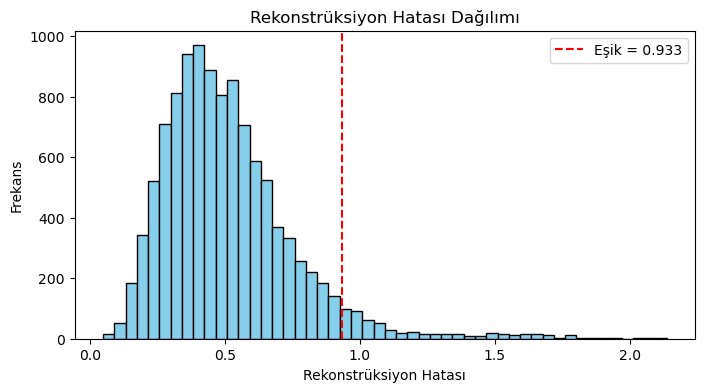

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df["recon_error"], bins=50, color="skyblue", edgecolor="black")
plt.axvline(thr, color="red", linestyle="--", label=f"Eşik = {thr:.3f}")
plt.title("Rekonstrüksiyon Hatası Dağılımı")
plt.xlabel("Rekonstrüksiyon Hatası")
plt.ylabel("Frekans")
plt.legend()
plt.show()


In [69]:
#Grafikte çoğu kayıt düşük hataya sahip ve normal görünüyor;
#kırmızı çizginin sağında kalan az sayıdaki kayıt ise yüksek hata nedeniyle anomali kabul ediliyor.


In [70]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = df["Reached.on.Time_Y.N"]  # 1 = geç kaldı, 0 = zamanında
y_pred = df["is_anomaly"]

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[4291  145]
 [6158  405]]

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.97      0.58      4436
           1       0.74      0.06      0.11      6563

    accuracy                           0.43     10999
   macro avg       0.57      0.51      0.35     10999
weighted avg       0.61      0.43      0.30     10999



In [71]:
#Sonuçlara göre model, zamanında teslim edilenleri (0) çok iyi yakalıyor (recall %97) 
#fakat geç kalanları (1) neredeyse hiç yakalayamıyor (recall %6). 
#Bu yüzden precision sınıf 1 için %73 olsa da recall çok düşük kaldığı için f1-score zayıf.
#Genel accuracy %57 civarında. Yani model normal örnekleri tanımakta iyi, ancak asıl önemli olan geç kalanları anomali olarak etiketlemede yetersiz.

In [72]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

percentiles = np.arange(80, 99.6, 0.5)  # 80–99.5
best = {"p": None, "thr": None, "prec":0, "rec":0, "f1":-1}

for p in percentiles:
    thr_p = np.percentile(df["recon_error"], p)
    y_hat = (df["recon_error"] > thr_p).astype(int)
    prec, rec, f1, sup = precision_recall_fscore_support(
        df["Reached.on.Time_Y.N"], y_hat, average="binary", pos_label=1
    )
    if f1 > best["f1"]:
        best.update({"p": p, "thr": thr_p, "prec":prec, "rec":rec, "f1":f1})

print(f"En iyi yüzde: {best['p']:.1f} | Eşik: {best['thr']:.6f} | P:{best['prec']:.2f} R:{best['rec']:.2f} F1:{best['f1']:.2f}")

thr = best["thr"]
df["is_anomaly"] = (df["recon_error"] > thr).astype(int)

print("Confusion Matrix:\n", confusion_matrix(df["Reached.on.Time_Y.N"], df["is_anomaly"]))
print("\nClassification Report:\n", classification_report(df["Reached.on.Time_Y.N"], df["is_anomaly"]))

En iyi yüzde: 80.0 | Eşik: 0.662436 | P:0.68 R:0.23 F1:0.34
Confusion Matrix:
 [[3729  707]
 [5070 1493]]

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.84      0.56      4436
           1       0.68      0.23      0.34      6563

    accuracy                           0.47     10999
   macro avg       0.55      0.53      0.45     10999
weighted avg       0.58      0.47      0.43     10999



In [73]:
#%80 eşiğinde modelin sınıf 1 için precision’ı %68’e yükseldi, recall %23’te kaldı, f1 %34 oldu;
#yani geç kalanları daha doğru tahmin ediyor ama azını yakalayabiliyor, genel doğruluk ise %48.

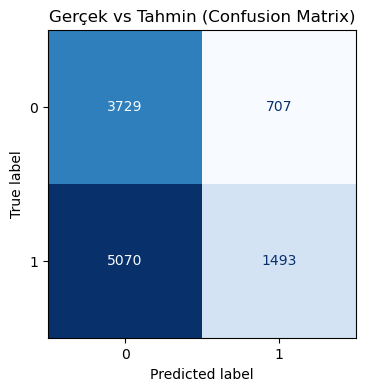

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    df["Reached.on.Time_Y.N"], df["is_anomaly"],
    cmap="Blues", ax=ax, colorbar=False
)
plt.title("Gerçek vs Tahmin (Confusion Matrix)")
plt.show()

/var/folders/_d/jfs9sfcd1t56yn93r71pt2km0000gn/T/ipykernel_23966/1627379234.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["is_anomaly"], y=df["recon_error"], palette="Set2")


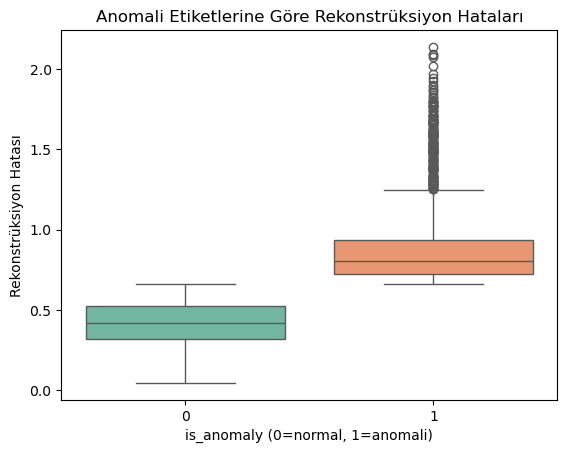

In [75]:
sns.boxplot(x=df["is_anomaly"], y=df["recon_error"], palette="Set2")
plt.title("Anomali Etiketlerine Göre Rekonstrüksiyon Hataları")
plt.xlabel("is_anomaly (0=normal, 1=anomali)")
plt.ylabel("Rekonstrüksiyon Hatası")
plt.show()